In [3]:
import sys
sys.path.append('../')

import json
import logging
import os
import math
import random
import shutil
from pathlib import Path
from itertools import chain

# from dotenv import load_dotenv
import torch
import numpy as np
import accelerate
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset, load_from_disk

# from lm_experiments_tools import Trainer, TrainerArgs
from lm_experiments_tools.trainer_accelerate import TrainerAccelerateArgs
from lm_experiments_tools.trainer_accelerate import TrainerAccelerate as Trainer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.distributed import DistributedSampler

from peft import get_peft_model, LoraConfig, TaskType

# from lm_experiments_tools import TrainerArgs
from lm_experiments_tools.trainer import Trainer

from torch.nn.utils.rnn import pad_sequence
# from lm_experiments_tools.lm_datasets import get_lm_datasets
from task_utils.contract_nli import process_file
import transformers  # noqa: E402
from transformers import AutoConfig, AutoTokenizer, HfArgumentParser  # noqa: E402

from lm_experiments_tools.utils import collect_run_configuration, get_cls_by_name, get_optimizer  # noqa: E402
import lm_experiments_tools.optimizers as optimizers  # noqa: E402

from matplotlib import pyplot as plt


libgomp: Invalid value for environment variable OMP_NUM_THREADS
/home/jovyan/envs/accel_rmt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-10-13 01:20:47,456] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:

# load_dotenv()

# logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
#                     level=logging.INFO)
# logger = logging.getLogger(__name__)

# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# # if CUDA_VISIBLE_DEVICES is not set make all gpus visible
# if os.environ.get('CUDA_VISIBLE_DEVICES', None) is None:
#     os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in range(torch.cuda.device_count())])

# logger.info(f"CUDA_VISIBLE_DEVICES: {os.environ['CUDA_VISIBLE_DEVICES']}")
# # first call to torch.cuda.device_count() sets visible gpus, following calls will not change the result
# logger.info(f"CUDA DEVICE COUNT: {torch.cuda.device_count()}")

# hvd.init()


# # limit # of CPU threads to be used per pytorch worker, otherwise it might use all cpus and throttle gpus
# # > 2 fails cause of https://github.com/pytorch/pytorch/issues/56615
# # need to upgrade to torch>1.8.1
# torch.set_num_threads(4)
# # all gpus set with CUDA_VISIBLE_DEVICES are visible to process, indexing from 0 to ...
# torch.cuda.set_device(hvd.local_rank())

# parser = HfArgumentParser(TrainerArgs)
# parser.add_argument('--task_name', type=str, help="Task name, wikitext, ...")
# parser.add_argument('--validate_only', action='store_true', default=False,
#                     help='Skip training and run only validation. (default: False)')
# parser.add_argument('--working_dir', type=str, default='.',
#                     help='working dir, should be a dir with t5-experiments repo (default: .)')
# parser.add_argument('--seed', type=int, default=42, help='random seed')
# parser.add_argument('--show_valid_examples', type=int, default=0,
#                     help='how many valid examples to show during training (default: 0)')
# parser.add_argument('--input_seq_len', type=int, default=128, help='input sequnce length (default: 128).')
# parser.add_argument('--target_seq_len', type=int, default=16, help='target sequnce length, should be set to '
#                                                                    'max(len(target))+1 for EOS (default: 16).')
# parser.add_argument('--data_n_workers', type=int, default=2, help='number of dataloader workers (default: 2)')

# parser.add_argument('--input_prefix', type=str, default='', help='add task prefix to an input string (default: "")')
# parser.add_argument('--sliding_window', action='store_true', help='use slinding window attentinon mask, '
#                     'eval on last segment only', default=False)

# # model args
# parser.add_argument('--from_pretrained', type=str, help='model name in HF Model Hub (default: "")')
# parser.add_argument('--model_cfg', type=str, help='path to model configuration file (default: "")')
# parser.add_argument('--model_cls', type=str, default='transformers:BertForPreTraining',
#                     help='model class name to use (default: transformers:BertForPreTraining)')
# parser.add_argument('--memory_cell_cls', type=str, default=None, help='cell class for RMT')
# parser.add_argument('--recurrent_wrapper_cls', type=str, default=None, help='recurrent wrapper class for RMT')
# parser.add_argument('--model_cpt', type=str, default=None, help='pretrained model checkpoint path')
# parser.add_argument('--backbone_cls', type=str, default=None,
#                     help='backbone class name to use for RMT')
# parser.add_argument('--model_type', type=str, default='encoder-decoder',
#                     help='model type, encoder, encoder-decoder, decoder, affects preprocessing '
#                          '(default: encoder-decoder)')


# # Aydar # RMT args 
# parser.add_argument('--input_size', type=int, default=None, help='maximal input size of the backbone model')
# parser.add_argument('--num_mem_tokens', type=int, default=None, help='number of memory tokens.')
# parser.add_argument('--max_n_segments', type=int, default=1, help='maximal segment number')
# # parser.add_argument('--sum_loss', action='store_true', default=False,
# #                     help='with this flag task loss from all segments is summed')
# # parser.add_argument('--bptt_depth', type=int, default=-1, help='max number of previous segments in gradient computation.')
# # parser.add_argument('--segment_ordering', type=str, help='segment order', default='regular',
# #                     choices=['regular', 'reversed', 'bidirectional', 'repeat_first', 'last_memory_only'])
# # parser.add_argument('--memory_forward_func', type=str, help='path to memory forward funсtion script', default=None)
# # parser.add_argument('--memory_layers', type=str, help='memory-augmented layer inds or "all" for all layers', default=None)
# # parser.add_argument('--share_memory_layers', action='store_true', help='share weights of memory layers', default=False)
# # parser.add_argument('--reconstruction_loss_coef', type=float, default=None,
# #                     help='reconstuction loss ratio in total loss')
# # # parser.add_argument('--segment_ordering', type=str,help='????', default='regular',
# # #                     choices=['regular', 'reversed', 'bidirectional', 'repeat_first', 'last_memory_only'])
# # parser.add_argument('--retain_graph', action='store_true', help='Retain computation graph during backward pass', default=False)
# # parser.add_argument('--use_truncated_backward', action='store_true', default=False,
# #                     help='whether to use RMT truncated bptt method in backward')
# # parser.add_argument('--k1', type=int, default=-1, help='(not implemented) If not -1, gradient update is done each k1 segments')
# parser.add_argument('--k2', type=int, default=-1, help='number of last segments used by backward')
# parser.add_argument('--freeze_model_weights', action='store_true', default=False,
#                     help='Stop training all model weights except memory layers')
# parser.add_argument('--backbone_cpt', type=str, default=None, help='backbone model checkpoint path')


# # tokenizer
# # todo: add wordpiece tokenizers support?
# parser.add_argument('--tokenizer', type=str, default=None, help='path or name of pre-trained HF Tokenizer')

# # optimizer args
# parser.add_argument('--optimizer', type=str, default='AdamW', help='optimizer name: AdamW, Adafactor. (default: AdamW)')
# parser.add_argument('--weight_decay', type=float, default=0.0, help='optimizer weight decay (default: 0.0)')
# parser.add_argument('--scale_parameter', action='store_true', default=False,
#                     help='Adafactor scale_parameter (default: False)')
# parser.add_argument('--relative_step', action='store_true', default=False,
#                     help='Adafactor relative_step (default: False)')
# parser.add_argument('--warmup_init', action='store_true', default=False,
#                     help='Adafactor warmup_init (default: False)')

In [5]:
class Holder:
    def __init__(self):
        pass
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return None

args = Holder()

In [6]:
# model_cpt = '/cephfs/home/bulatov/bulatov/RMT_light/runs/contract_nli/gpt2/linear_adamw_wd1e-03_124-128-1x128_mem2_bs128_regular_bptt-1_from_cpt_0-1/run_1/'
# model_cpt = "/cephfs/home/bulatov/bulatov/RMT_light/runs/contract_nli/gpt2/linear_adamw_wd1e-03_118-128-1x128_mem5_bs128_regular_bptt-1_from_cpt_0-1/run_1"
# model_cpt = '/cephfs/home/bulatov/bulatov/RMT_light/runs/contract_nli/gpt2/lr5e-05_linear_adamw_wd1e-03_236-128-2x128_mem5_bs128_iters1500_regular_bptt-2/run_1'

In [7]:
# import json
# with open(model_cpt + '/config.json', 'r') as f:
#     config = json.load(f)

# config

In [8]:
attrs = ("--model_path", "/home/jovyan/rmt/runs/test/pile",
"--from_pretrained", "EleutherAI/pythia-70m-deduped",
"--task_name", "qasper",
"--model_type", "decoder",
"--memory_cell_cls", "modeling_rmt.language_modeling:MemoryCell",
"--recurrent_wrapper_cls", "modeling_rmt.language_modeling:RecurrentWrapper",
"--model_cls",  "base_models.modeling_gpt_neox:GPTNeoXForCausalLM",
"--segment_alignment", "right",
# "--model_cpt", model_cpt,
"--optimizer", "AdamW",
"--weight_decay", "0.001",
"--lr", "1e-03", 
"--lr_scheduler", "constant_with_warmup",
"--clip_grad_value", "5.0")

int_attrs = (
    
# "--input_seq_len", "118",
"--block_size", "124",
"--input_size", "128",
"--history_size", "372",
"--num_mem_tokens", "2",
"--max_n_segments" ,"4", 
"--batch_size", "2", 
"--gradient_accumulation_steps", "1",
"--iters", "100",
"--num_warmup_steps", "100",
"--data_n_workers", "2",
"--log_interval", "10",
"--show_valid_examples", "5",
"--early_stopping_patience", "15",
"--seed", "42",
"--k2", "-1",)

In [9]:
for a, v in zip(int_attrs[::2], int_attrs[1::2]):
    setattr(args, a.split('--')[1], int(v))

for a, v in zip(attrs[::2], attrs[1::2]):
    try:
        setattr(args, a.split('--')[1], float(v))
    except ValueError:
        setattr(args, a.split('--')[1], v)

In [10]:

# args = parser.parse_args()
# set current working dir
# args.working_dir = str(Path(args.working_dir).expanduser().absolute())
# os.chdir(args.working_dir)
# if hvd.rank() == 0:
#     logger.info(f'hvd size: {hvd.size()}')
#     logger.info(f'FP16: {args.fp16}')

# if hvd.rank() == 0 and args.model_path is None:
#     logger.warning('model_path is not set: config, logs and checkpoints will not be saved.')

# # create model path and save configuration
# if hvd.rank() == 0 and args.model_path is not None:
#     model_path = Path(args.model_path)
#     if not model_path.exists():
#         Path(model_path).mkdir(parents=True)
#     args_dict = collect_run_configuration(args)
#     # todo: if model path exists and there is config file, write new config file aside
#     json.dump(args_dict, open(model_path/'config.json', 'w'), indent=4)

if not args.from_pretrained:
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer)
else:
    tokenizer = AutoTokenizer.from_pretrained(args.from_pretrained)


In [11]:
def tokenization(sample):
    return tokenizer.encode(sample["text"])

class BlockDataLoader(DataLoader):
    def __init__(self, dataset, block_size, history_size, max_samples=None, shuffle=False, *args, **kwargs):
        super().__init__(dataset, *args, **kwargs)
        self.block_size = block_size
        self.history_size = history_size
        self.max_samples = max_samples
        self.shuffle = shuffle
            
    def get_samples(self, document):
        input_ids = tokenizer.encode(document['text'])
        # do not load short documents
        if len(input_ids) < self.block_size:
            return []
        if args.min_tokens_in_document is not None and len(input_ids) < args.min_tokens_in_document:
            return []
        # samples = [input_ids[max({0, start - self.history_size - self.block_size}): start] for start in range(self.block_size + self.history_size, len(input_ids), self.block_size)]
        samples = [input_ids[max({0, start - self.history_size - self.block_size}): start] for start in range(self.block_size, len(input_ids), self.block_size)]
        
        
        # samples = [input_ids[start: start + self.block_size] for start in range(self.history_size, len(input_ids), self.block_size)]
        # print('samples', [len(s) for s in samples])
        # print('input_ids', len(input_ids))
        return samples
    
    def __iter__(self):
        inds = list(range(len(self.dataset)))

        if self.max_samples is not None:
            inds = inds[:self.max_samples]

        if self.shuffle: 
            np.random.shuffle(inds)

        doc_ind = 0
        samples = []

        while True:
            if doc_ind >= len(inds):
                break
            try: 
                while len(samples) < self.batch_size:
                    document = self.dataset[inds[doc_ind]]
                    doc_ind += 1
                    samples += self.get_samples(document)
                    if doc_ind >= len(inds):
                        raise(StopIteration)
            except(StopIteration):
                pass

            batch, samples = samples[:self.batch_size], samples[self.batch_size:]
            # print('batch', [len(b) for b in batch])
            # print('samples', [len(b) for b in samples])
            yield self.collate_fn(batch)

In [12]:
block_size = args.block_size if args.block_size is not None else args.input_size
history_size = args.history_size


id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
def collate_fn(batch):
    input_ids = labels = [torch.tensor(b) for b in batch]
    attention_mask = [torch.ones_like(b, dtype=int) for b in input_ids]
    labels_mask = [torch.ones_like(b, dtype=int) for b in input_ids]
    for m in labels_mask:
        m[:-block_size] = False
    
    input_ids = pad_sequence(input_ids, padding_value=id_pad_value, batch_first=True)
    labels = pad_sequence(labels, padding_value=-100, batch_first=True)
    attention_mask = pad_sequence(attention_mask, padding_value=0, batch_first=True)
    labels_mask = pad_sequence(labels_mask, padding_value=0, batch_first=True)

    collated = {'input_ids': input_ids,
                'labels': labels, 
                'attention_mask': attention_mask}
    
    if input_ids.shape[1] != block_size:
        collated['labels_mask'] = labels_mask.bool()

    if getattr(args, 'vary_n_segments', False):
        if getattr(args, 'sampling_prob', False):
            random_value = torch.rand((1)).item()
            if random_value > args.sampling_prob:
                return collated
            
        n_segments = random.randint(0, args.max_n_segments)
        n_tokens = n_segments * block_size
        for k in collated:
            collated[k] = collated[k][:, -n_tokens:]
    
    # print('\n\n\ninput_ids', input_ids.shape)
    # print('collated', collated)
    return collated

In [13]:
len(tokenizer.vocab)

50277

In [14]:

dataset = load_dataset('/home/jovyan/rmt/datasets/pile/data')

Resolving data files: 100%|██████████| 30/30 [00:00<00:00, 179755.89it/s]

In [15]:
train_dataset, valid_dataset, test_dataset = dataset["train"], dataset["validation"], dataset["test"]


# shuffle train data each epoch (one loop over train_dataset)
train_rnd_generator = torch.Generator()
train_rnd_generator.manual_seed(args.seed)
per_worker_batch_size = args.batch_size * args.gradient_accumulation_steps
kwargs = {'pin_memory': True, 'num_workers': args.data_n_workers}
    
# train_sampler = DistributedSampler(train_dataset, shuffle=True)
train_dataloader = BlockDataLoader(train_dataset, batch_size=per_worker_batch_size,  #generator=train_rnd_generator,
                                # sampler=train_sampler,
                                block_size=block_size, 
                                history_size=history_size, 
                                shuffle=True,
                                collate_fn=collate_fn, **kwargs)

# get validation dataset
max_samples = 5000 if args.validate_only else 100
# max_samples = 100
valid_dataloader = None
# logger.info(f'preparing validation data')
# valid_sampler = DistributedSampler(valid_dataset, shuffle=True)
valid_dataloader = BlockDataLoader(valid_dataset, batch_size=per_worker_batch_size,
                                # sampler=valid_sampler,
                                block_size=block_size, 
                                history_size=history_size, 
                                shuffle=False,
                                max_samples=max_samples,
                                collate_fn=collate_fn, drop_last=True, **kwargs)

In [16]:
model_cls = get_cls_by_name(args.model_cls)

# logger.info(f'Using model class: {model_cls}')

if args.use_adapter:
    model_cfg = AutoConfig.from_pretrained(args.from_pretrained)

    model_cfg.use_parallel_adapter = args.use_adapter
    model_cfg.parallel_adapter_mode = 'ffn'
    model_cfg.adapter_bottleneck_dim = args.adapter_bottleneck_dim
    model_cfg.adapter_dropout = args.adapter_dropout
    model_cfg.adapter_scale = args.adapter_scale

    model = model_cls(config=model_cfg)

    # logger.info(f'Loading pretrained model: {args.from_pretrained}')
    base_model = model_cls.from_pretrained(args.from_pretrained, use_safetensors=False)

    model.load_state_dict(base_model.state_dict(), strict=False)
    del base_model
    # logger.info(f'Added adapters')

else:
    if not args.from_pretrained:
        model_cfg = AutoConfig.from_pretrained(args.model_cfg)
        model = model_cls(config=model_cfg)
    else:
        # logger.info(f'Loading pretrained model: {args.from_pretrained}')
        model = model_cls.from_pretrained(args.from_pretrained, use_safetensors=False)

if args.use_lora:
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, 
        inference_mode=False, 
        r=args.lora_attn_dim, 
        lora_alpha=args.lora_attn_alpha, 
        lora_dropout=args.lora_dropout
        )
    model = get_peft_model(model, peft_config)
    # logger.info(f'Added LoRA, trainable parameters with LoRA only:')
    model.print_trainable_parameters()


## load cpt of backbone model
if args.backbone_cpt:
    backbone_cpt = os.path.join(args.backbone_cpt, "model_best/pytorch_model.bin")
    # model = torch.load(backbone_cpt, map_location='cpu')
    cpt = torch.load(backbone_cpt, map_location='cpu')
    model.load_state_dict(cpt, strict=False)
    # logger.info(f'Loaded baseline state dict from: {args.backbone_cpt}')

# Pass memory settings to pretrained model
if args.num_mem_tokens is not None:
    memory_cell_cls = get_cls_by_name(args.memory_cell_cls)
    recurrent_wrapper_cls = get_cls_by_name(args.recurrent_wrapper_cls)
    # logger.info(f'Wrapping in: {memory_cell_cls} and {recurrent_wrapper_cls}')
    
    base_model_forward = args.base_model_forward
    if base_model_forward is not None:
        base_model_forward = get_cls_by_name(base_model_forward)
        # logger.info(f"Using custom forward function: {base_model_forward}")
    cell = memory_cell_cls(model, args.num_mem_tokens)
    # if args.segment_alignment not in {None, 'left'}:
        # logger.info(f"Using custom segment alignment: {args.segment_alignment}")
    model = recurrent_wrapper_cls(cell, 
                                    segment_size=block_size,
                                    max_n_segments=args.max_n_segments, 
                                    vary_n_segments=args.vary_n_segments,
                                    segment_alignment=args.segment_alignment,
                                    k2=args.k2,
                                    base_model_forward_func=base_model_forward
    )
                                

    ## load cpt of rmt
    if args.model_cpt:
        model_cpt = os.path.join(args.model_cpt, "model_best/pytorch_model.bin")
        # model = torch.load(model_cpt, map_location='cpu')
        cpt = torch.load(model_cpt, map_location='cpu')
        # print(cpt.keys())
        model.load_state_dict(cpt, strict=False)
        # logger.info(f'Loaded RMT state dict from: {args.model_cpt}')

In [17]:

# define optimizer
optimizer_cls = get_optimizer(args.optimizer)
if optimizer_cls is None:
    raise RuntimeError(f'{args.optimizer} was not found in optimizers, torch.optim, transformers.optimization')

# if hvd.rank() == 0:
#     logger.info(f'Using optimizer class: {optimizer_cls}')

# todo: group optimizer params
if optimizer_cls in [transformers.optimization.Adafactor, optimizers.Adafactor]:
    # https://github.com/huggingface/transformers/pull/9751/files -> transformers 4.3.0
    optimizer = optimizer_cls(model.parameters(), lr=args.lr,
                                scale_parameter=args.scale_parameter,
                                relative_step=args.relative_step,
                                warmup_init=args.warmup_init,
                                weight_decay=args.weight_decay)
else:
    optimizer = optimizer_cls(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

def keep_for_metrics_fn(batch, output):
        # select data from batch and model output that would be used to compute metrics
        data = {}
        data['labels'] = batch['labels']
        data['loss'] = output['loss']
        if 'logits' in output:
            data['predictions'] = torch.argmax(output['logits'].detach(), dim=-1)
        return data


In [18]:
model.memory_cell.model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [19]:
[key for key, _ in model.named_modules()]

['',
 'memory_cell',
 'memory_cell.model',
 'memory_cell.model.gpt_neox',
 'memory_cell.model.gpt_neox.embed_in',
 'memory_cell.model.gpt_neox.emb_dropout',
 'memory_cell.model.gpt_neox.layers',
 'memory_cell.model.gpt_neox.layers.0',
 'memory_cell.model.gpt_neox.layers.0.input_layernorm',
 'memory_cell.model.gpt_neox.layers.0.post_attention_layernorm',
 'memory_cell.model.gpt_neox.layers.0.post_attention_dropout',
 'memory_cell.model.gpt_neox.layers.0.post_mlp_dropout',
 'memory_cell.model.gpt_neox.layers.0.attention',
 'memory_cell.model.gpt_neox.layers.0.attention.rotary_emb',
 'memory_cell.model.gpt_neox.layers.0.attention.query_key_value',
 'memory_cell.model.gpt_neox.layers.0.attention.dense',
 'memory_cell.model.gpt_neox.layers.0.attention.attention_dropout',
 'memory_cell.model.gpt_neox.layers.0.mlp',
 'memory_cell.model.gpt_neox.layers.0.mlp.dense_h_to_4h',
 'memory_cell.model.gpt_neox.layers.0.mlp.dense_4h_to_h',
 'memory_cell.model.gpt_neox.layers.0.mlp.act',
 'memory_cell.m

In [15]:
def metrics_fn(data):
    # compute metrics based on stored labels, predictions, ...
    metrics = {}
    if 'predictions' in data:
        y, p = data['labels'], data['predictions']
        if args.show_valid_examples > 0:
            for i in range(min(args.show_valid_examples, len(y))):
                # logger.info(f'y: {y[i][:100]}')
                # logger.info(f'p: {p[i][:100]}')
                # pred = p[i][p[i] != -100]
                # lab = y[i][y[i] != -100]
                # logger.info(f'pred: {pred}')
                # logger.info(f'lab: {lab}')
                pred = p[i]
                lab = y[i]
                # try:
                #     logger.info(f'y: {tokenizer.decode(lab)[:100]}')
                # except OverflowError as e:
                #     logger.info(f"Error in decoding labels: {e}, {lab[:100]}")
                # try:
                #     logger.info(f'y: {tokenizer.decode(pred)[:100]}')
                # except OverflowError as e:
                #     logger.info(f"Error in decoding predictions: {e}, {pred[:100]}")
                
                # logger.info('-' * 50)
    try:
        perplexity = math.exp(data["loss"].mean())
    except OverflowError:
        perplexity = float("inf")
    metrics["perplexity"] = perplexity

    return metrics

In [18]:
eval_sample = valid_dataset[:5000]
eval_tokenized = list(map(tokenizer.encode, eval_sample['text']))
eval_lens = [len(l) for l in eval_tokenized]

In [37]:
len([len(l) for l in eval_tokenized if len(l) > 2044 ])

641

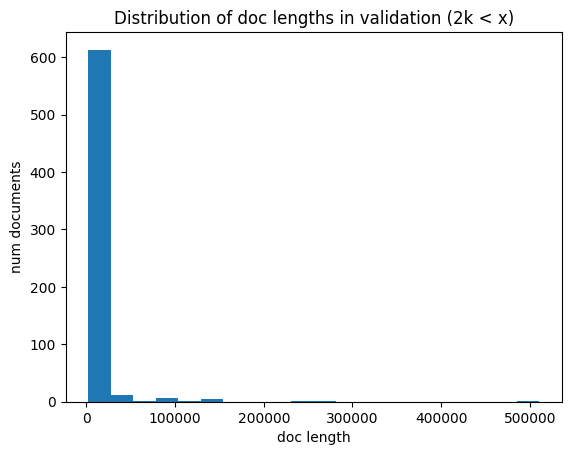

In [36]:
plt.hist([len(l) for l in eval_tokenized if len(l) > 2044 ], bins=20)
plt.xlabel('doc length')
plt.ylabel('num documents')
plt.title('Distribution of doc lengths in validation (2k < x)')
plt.show()

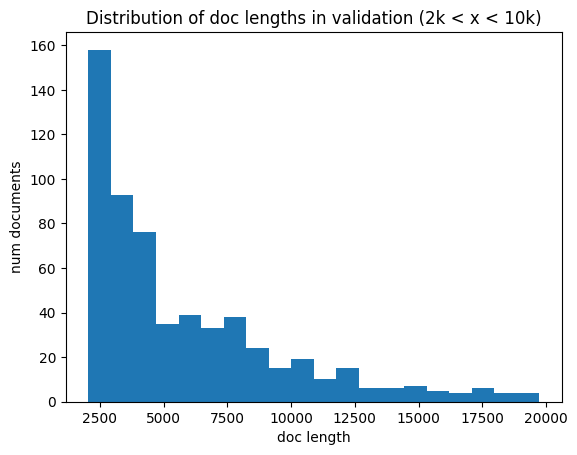

In [38]:
plt.hist([len(l) for l in eval_tokenized if len(l) > 2044 and len(l) < 20000], bins=20)
plt.xlabel('doc length')
plt.ylabel('num documents')
plt.title('Distribution of doc lengths in validation (2k < x < 10k)')
plt.show()

In [29]:
train_gen=iter(train_dataloader)
train_batch = next(train_gen)
train_batch.keys(), train_batch['input_ids'].shape

dict_keys(['input_ids', 'labels', 'attention_mask', 'labels_mask'])

In [37]:
train_batch = next(train_gen)
train_batch['input_ids'].shape

torch.Size([2, 496])

In [38]:
train_batch['labels_mask']

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [35]:
# idx = train_batch.pop('id')
# target_text = train_batch.pop('target_text')
# input_ids_generate = train_batch.pop('input_ids_generate')
# attention_mask_generate = train_batch.pop('attention_mask_generate')

out = model(**train_batch)
out.loss

tensor(4.3937, grad_fn=<NllLossBackward0>)

In [36]:
tokenizer.decode(train_batch['input_ids'][0])

'Our mission with Ubuntu is to deliver, in the cleanest, most economical and most reliable form, all the goodness that engineers love about free software to the widest possible audience (including engineers :)). We’ve known for a long time that free software is beautiful on the inside – efficient, accurate, flexible, modifiable. For the past three years, we’ve been leading the push to make free software beautiful on the outside too – easy to use, visually pleasing and exciting. That started with the Ubuntu Netbook Remix, and is coming to fruition in 12.04 LTS, now in beta.\n\nFor the first time with Ubuntu 12.04 LTS, real desktop user experience innovation is available on a full production-ready enterprise-certified free software platform, free of charge, well before it shows up in Windows or MacOS. It’s not ‘job done’ by any means, but it’s a milestone. Achieving that milestone has tested the courage and commitment of the Ubuntu community – we had to move from being followers and inte

In [24]:
train_dataset[0]

{'id': '753990d0b621d390ed58f20c4d9e4f065f0dc672',
 'pid': '753990d0b621d390ed58f20c4d9e4f065f0dc672_0',
 'input': 'What is the seed lexicon?\n\nIntroduction\nAffective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one\'s wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing the polarity of an affective event that is represented by a score ranging from $-1$ (negative) to 1 (positive).\nLearning affective events is challenging because, as the examples above suggest, the polarity of an event is not necessarily predictable from its constituent words. Combined with the unbounded combinatorial nature of language, the non-compositionality

In [36]:
keep_for_metrics_fn(train_batch, out)

{}

In [25]:
valid_gen=iter(train_dataloader)
valid_batch = next(valid_gen)
valid_batch.keys()

dict_keys(['input_ids', 'labels', 'input_ids_generate', 'labels_mask', 'attention_mask', 'id', 'target_text'])

In [26]:
input_ids = valid_batch['input_ids']

In [28]:
gen_out = model.generate(input_ids, attention_mask=valid_batch['attention_mask'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/jovyan/envs/accel_rmt/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [30]:
gen_text = tokenizer.batch_decode(gen_out)
gen_text

['<|endoftext|>[GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN]',
 '<|endoftext|>[GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN]']

In [34]:
tokenizer.decode(train_batch['input_ids'][0])

"What is the seed lexicon?\n\nIntroduction\nAffective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing[GEN]a vocabulary of positive and negative predicates that helps determine the polarity score of an event"

In [40]:
data = dict(**valid_batch)
data['generation_outputs'] = gen_out

In [42]:
metrics_fn(data)

{'exact_match': 0.0, 'f1': 0.0}

In [41]:
keep_for_metrics_fn(valid_batch, gen_out)

RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.